2023.05.22 박진윤 선임연구원, 태안군 인공지능유합산업진흥원

## 작업환경 확인

In [1]:
# 현재 위치 확인
!pwd

/tf/repos/07_HomeTraining/230208_jy


In [2]:
# 학습 할때 몇 번째 gpu를 사용할것인지 설정
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"  # specify which GPU(s) to be used

In [3]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore')
curdir = os.getcwd()
print(curdir)

/tf/repos/07_HomeTraining/230208_jy


In [4]:
# 서버 이름
import socket
hostname = socket.gethostname()
print(hostname)

f1b2c6893cf4


In [5]:
def createFolder(directory):
    try:
        if os.path.exists(directory):
            print('Already Exists')
        if not os.path.exists(directory):
            os.makedirs(directory)
            print('Sucess creating directory.' + directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

## 필요 라이브러리 import

In [6]:
import sys
sys.path.append(os.pardir)
sys.path.append('./common')

In [7]:
%matplotlib inline
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm 
import pickle
from sklearn.model_selection import train_test_split

from Quaternion import *
from  DDUtil import GetTimeString
from  DDUtil import MakeDir
from  DDUtil import *
from DataSet2 import skipper
from DataSet2 import NormalizeData
from DataSet2 import GetSizeForBatch
import DataSet2
import DataSet2 as motion

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-n9h2vq9p because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [8]:
from transformer import MultiHeadSelfAttention
from transformer import TransformerBlock
#from transformer import TokenAndPositionEmbedding
from transformer import TokenAndPositionEmbedding2

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import Flatten, Masking, Add

from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import SimpleRNN, AveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

In [10]:
from Attention import Attention

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import random
import math

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelBinarizer
# from keras_flops import get_flops #pip install keras-flops

In [12]:
tstring = GetTimeString()
print(tstring)

20230810_043631


In [13]:
np.random.seed(1214)

In [14]:
# 텐서플로우 버전이 2.3.0 이 아니면 중단
print(tf.__version__)
# assert tf.__version__=='2.3.0'

2.8.0


## 데이터 불러오기

In [15]:
outdir_pickle = './pickle'
fn_pickle_pub = '{}/0531_elderly_youtube_class4_len_all_pub.pickle'.format(outdir_pickle)
print(fn_pickle_pub)

./pickle/0531_elderly_youtube_class4_len_all_pub.pickle


In [16]:
# change all the necessary information for the according dataset
dataset_name = fn_pickle_pub.split('/')[-1].split('_')[1]
print(f'This notebook is working on {dataset_name} dataset')

if dataset_name == 'UTK':
    spine_joint_index = 1 
    num_joints = 20
    nbsample_crop = 70 
    right_hip_joint_index = 16
    left_hip_joint_index = 12
    mid_hip_joint_index = 0
    neck_joint_index = 2
elif dataset_name == 'FLO':
    spine_joint_index = 2 
    num_joints = 15
    nbsample_crop = 35 
    right_hip_joint_index = 12
    left_hip_joint_index = 9
    mid_hip_joint_index = 2
    neck_joint_index = 1
elif dataset_name == 'MSRA':
    spine_joint_index = 1
    num_joints = 20
    nbsample_crop = 70 
    right_hip_joint_index = 4
    left_hip_joint_index = 5
    mid_hip_joint_index = 6
    neck_joint_index = 2
elif dataset_name == 'elderly':
    spine_joint_index = 7 
    num_joints = 17
    nbsample_crop = 60 
    right_hip_joint_index = 1
    left_hip_joint_index = 4
    mid_hip_joint_index = 0
    neck_joint_index = 8
else: #H36M
    spine_joint_index = 7 
    num_joints = 17
    nbsample_crop = 100 
    right_hip_joint_index = 1
    left_hip_joint_index = 4
    mid_hip_joint_index = 0
    neck_joint_index = 8

seq_length = nbsample_crop
pad_value = 0

This notebook is working on elderly dataset


In [17]:
createFolder(f'./out/{dataset_name}/')

Already Exists


In [18]:
loadFromPickle = True  #True #False

In [19]:
if loadFromPickle:
    if os.path.exists(fn_pickle_pub):
        print('{} exists....OK'.format(fn_pickle_pub))

        print('load from pickle files')
        file = open(fn_pickle_pub, 'rb')
        data = pickle.load(file)
        file.close()
        print(np.shape(data))
        dataset = data[0]
        labels = data[1]  
        class_name_pub = data[2]  
        dname = data[3] 
        tstring = data[4]

./pickle/0531_elderly_youtube_class4_len_all_pub.pickle exists....OK
load from pickle files
(5,)


In [20]:
class_name_pub

['C00', 'C01', 'C02', 'C03']

In [21]:
n_classes = len(class_name_pub)
n_classes

4

In [22]:
np.shape(dataset[0]), np.shape(labels[0])

((60, 51), (4,))

In [23]:
class MyPaddingSeq3d():
    def __init__(self, maxlen=None, pad_value=0.0):
        super(MyPaddingSeq3d, self).__init__()
        self.maxlen  = maxlen 
        self.pad_value = pad_value
    
    def ddd(self, sequences):
        sequences_out = []
        
        seq_num = len(sequences)
        print(seq_num)
        for i in range(seq_num):
            seq_1 = sequences[i]
            seq_1 = list(seq_1)
            #print(len(seq_1))
            dim = np.shape(seq_1[-1])[0]
            if len(seq_1) < self.maxlen:
                p = np.full((self.maxlen - len(seq_1), dim), self.pad_value)
                s = np.vstack((seq_1, p))
                sequences_out.append(s)
                
            elif len(seq_1) >= self.maxlen:
                x = seq_1[:self.maxlen]
                sequences_out.append(x)
            
        return np.array(sequences_out)

In [24]:
pad = MyPaddingSeq3d(maxlen = nbsample_crop, pad_value = pad_value)

In [25]:
if dataset_name in['MSRA', 'FLO', 'UTK']:
    padded_data = pad.ddd(dataset)
    print('padded')
else:
    padded_data = dataset.copy()
    print('not padded')

not padded


``` python
((14280, 100, 75), (14280, 10), (6243, 100, 75), (6243, 10))
```

In [26]:
np.shape(padded_data), np.shape(labels)

((1265, 60, 51), (1265, 4))

In [27]:
np.shape(padded_data[:, :, 1:1*4])

(1265, 60, 3)

In [28]:
padded_data[0].shape

(60, 51)

In [29]:
for i in range(len(class_name_pub)):
    print(i, class_name_pub[i])

0 C00
1 C01
2 C02
3 C03


```
(AS1) Horizontal arm wave, hammer, forward punch, high throw, hand clap, bend, tennis serve, pickup & throw 

(AS2) high arm wave, hand catch, draw x, draw tick, draw circle, two hand wave, forward kick, side boxing 

(AS3) high thorw, forward kick, side kick, jogging, tennis swing, tennis serve, gold swing, pickup & throw
```

In [30]:
case = 'AS2'

In [31]:
if dataset_name == 'MSRA':
    if case == 'AS1':
        idx = [12, 7, 4, 11, 9, 0, 17, 14]
    elif case == 'AS2':
        idx = [10, 8, 3, 2, 1, 19, 5, 15]
    elif case == 'AS3':
        idx = [11, 5, 16, 13, 17, 18, 6, 14]

    print(idx)
else:
    case = 'None'
    print('passed on choosing action set')

passed on choosing action set


In [32]:
k = 0
for sample in range(len(padded_data)):
    if dataset_name == 'MSRA':
        if np.argmax(labels[sample]) in idx:
            temp = [padded_data[sample]]
            lbl = labels[sample]
    #         print(np.shape(temp))
        else:
            continue
    else:
        temp = [padded_data[sample]]
        lbl = labels[sample]
        
    if k == 0:
        temp_stack = temp
        lbl_stack = lbl
        k+=1
    else:
        temp_stack = np.vstack((temp_stack, temp))
        lbl_stack = np.vstack((lbl_stack, lbl))

padded_data_case = temp_stack
labels_case = lbl_stack
print('-------------------------------------------')
print('selected actions', np.shape(padded_data_case), np.shape(labels_case))

-------------------------------------------
selected actions (1265, 60, 51) (1265, 4)


In [33]:
datadim = np.shape(padded_data_case[0])[-1]
datadim

51

In [34]:
n_timesteps, n_features, n_outputs = seq_length, datadim, n_classes
print(n_timesteps, n_features, n_outputs)

60 51 4


## 학습

In [35]:
to_Train = True

In [37]:
training_epochs = 100

In [38]:
# 221226
# https://velog.io/@noooooh_042/논문-구현GoogleNetv1
def inception(x_in, x1_f,x3r_f,x3_f,x5r_f,x5_f,po):
    x1 = MaxPooling1D(pool_size=3,strides=1,padding = 'SAME')(x_in)
    x1 = Conv1D(filters= po,kernel_size=1,padding="SAME")(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv1D(filters=x5r_f,kernel_size=1,padding="SAME")(x_in)
    x2 = Conv1D(filters=x5_f,kernel_size=5,padding="SAME")(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv1D(filters=x3r_f,kernel_size=1,padding="SAME")(x_in)
    x3 = Conv1D(filters=x3_f,kernel_size=3,padding="SAME")(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv1D(filters=x1_f,kernel_size=1,padding="SAME")(x_in)
    x4 = Activation('relu')(x4)

    out = Concatenate()([x1,x2,x3,x4])
    return out

In [39]:
n_outputs

4

https://github.com/keras-team/keras-io/blob/master/examples/nlp/text_classification_with_transformer.py https://keras.io/examples/nlp/text_classification_with_transformer/

In [53]:
# 원본
def make_transformer(maxlen, data_dim, embed_dim, num_heads, ff_dim, return_logit_only=False, return_weights=False):
    #maxlen =  200  # Only consider the first 200 words of each movie review
    # data_dim = 6
    #inputs = layers.Input(shape=(maxlen,))
    
    inputs = layers.Input(shape=(maxlen, data_dim )) 
    if False:
        embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        x = embedding_layer(inputs)
    else:

        embedding_layer = TokenAndPositionEmbedding2(maxlen, embed_dim) #100,  32 (<--- was 6)
        x = embedding_layer(inputs)
        #x = layers.Dense(embed_dim, activation="relu")(inputs)


    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    vattn_weights =[]
    if return_weights:
        x, attn_weights1 = transformer_block(x,training = True, return_weights = return_weights)#
        vattn_weights.append(attn_weights1)
        
        x, attn_weights2 = transformer_block(x,training=True, return_weights = return_weights)#
        vattn_weights.append(attn_weights2)
        
        x, attn_weights3 = transformer_block(x,training=True, return_weights = return_weights)#
        vattn_weights.append(attn_weights3)
        
        x, attn_weights4 = transformer_block(x,training=True, return_weights = return_weights)#
        vattn_weights.append(attn_weights4)
        
    else:
        x = transformer_block(x,training = True, return_weights = return_weights)#

        x = transformer_block(x,training=True, return_weights = return_weights)#
        x = transformer_block(x,training=True, return_weights = return_weights)
        x = transformer_block(x,training=True, return_weights = return_weights)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)   #0.1
    #x = layers.Dense(20, activation="relu")(x)
    #x = layers.Dropout(0.1)(x)
    
    if return_logit_only:
        outputs = x
    else:
        outputs = layers.Dense(n_classes, activation="softmax")(x)
        
    # transformer_block._name
    model = keras.Model(inputs=inputs, outputs=outputs)
    if return_weights:
        
        return model, vattn_weights
    else:
        return model

In [54]:
embed_dim = 64 #32 #64 #12 #8 #16 # Embedding size for each token
num_heads = 4 #4#1 # Number of attention heads
ff_dim = embed_dim*1 #32*2*4  # Hidden layer size in feed forward network inside transformer

In [55]:
model, atten_wieghts = make_transformer(nbsample_crop, datadim, embed_dim, num_heads, ff_dim, return_weights = True)

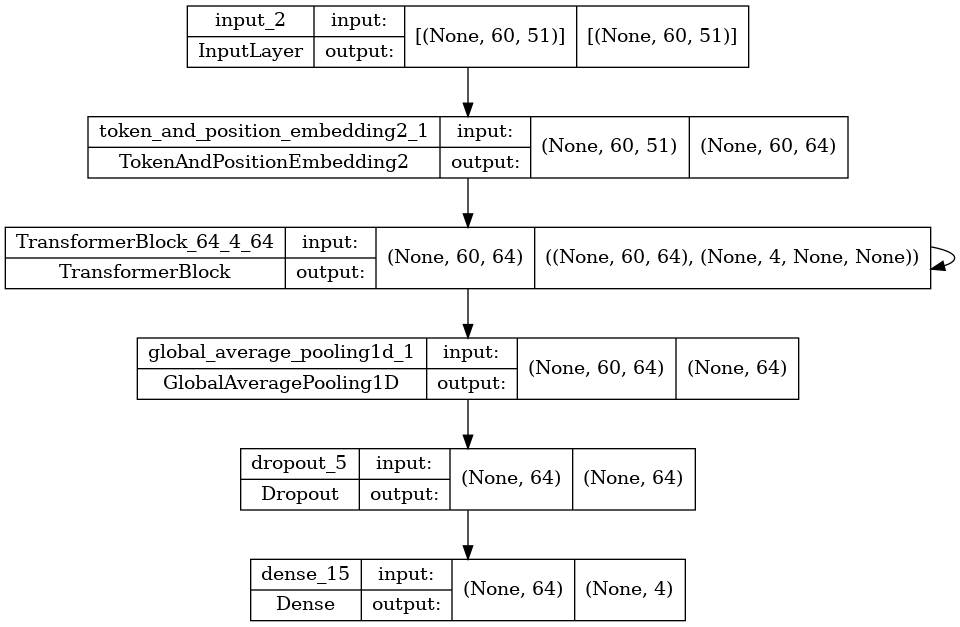

In [56]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./model_transformer.png', show_shapes=True)

from IPython.display import Image
Image('./model_transformer.png')

In [44]:
lr_schedule(0)

Learning rate:  0.001


0.001

##### training - ablation study

In [45]:
n_timesteps,n_features

(60, 51)

In [46]:
Augmentation =True
ViewNorm = False #whether setting viewnorm for train data
aug_count = 20 #2,4,7,10,15,20

model_type = 'Transformer' #ResNet, Conv1D, GoogleNet

seed_value = 1214
batch_size = 16

In [47]:
padded_data_case.shape, labels_case.shape

((1265, 60, 51), (1265, 4))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(padded_data_case, 
                                                    labels_case, 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=1214)

In [49]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((885, 60, 51), (885, 4), (380, 60, 51), (380, 4))

In [59]:
## ablation study according to number of heads
acc = list()

for heads in [1,2,4,8]:

    embed_dim = 64 
    ff_dim = embed_dim*1 

    model, atten_wieghts = make_transformer(nbsample_crop, datadim, embed_dim, heads, ff_dim, return_weights = True)

    out_dir = f'./out/{dataset_name}/'

    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=lr_schedule(0)), 
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=training_epochs,
              verbose=False)

    model.save(out_dir+f'{dataset_name}_{model_type}_{heads}heads')

    ### -----------------------------t-e-s-t----------------------------------- ###
    print('---Testing---')
    scores = model.evaluate(X_test, y_test, verbose=1)
    acc.append(scores[1] * 100)
    print(f'Score: {model.metrics_names[1]} of {scores[1]*100}%')


Learning rate:  0.001


INFO:tensorflow:Assets written to: ./out/elderly/elderly_Transformer_1heads/assets


INFO:tensorflow:Assets written to: ./out/elderly/elderly_Transformer_1heads/assets


---Testing---
12/12 [==============================] - 1s 7ms/step - loss: 0.4591 - accuracy: 0.8658
Score: accuracy of 86.57894730567932%
Learning rate:  0.001


INFO:tensorflow:Assets written to: ./out/elderly/elderly_Transformer_2heads/assets


INFO:tensorflow:Assets written to: ./out/elderly/elderly_Transformer_2heads/assets


---Testing---
12/12 [==============================] - 1s 8ms/step - loss: 0.4699 - accuracy: 0.8579
Score: accuracy of 85.78947186470032%
Learning rate:  0.001


INFO:tensorflow:Assets written to: ./out/elderly/elderly_Transformer_4heads/assets


INFO:tensorflow:Assets written to: ./out/elderly/elderly_Transformer_4heads/assets


---Testing---
12/12 [==============================] - 1s 8ms/step - loss: 0.4340 - accuracy: 0.8737
Score: accuracy of 87.36842274665833%
Learning rate:  0.001


INFO:tensorflow:Assets written to: ./out/elderly/elderly_Transformer_8heads/assets


INFO:tensorflow:Assets written to: ./out/elderly/elderly_Transformer_8heads/assets


---Testing---
12/12 [==============================] - 1s 8ms/step - loss: 0.3306 - accuracy: 0.8974
Score: accuracy of 89.73684310913086%


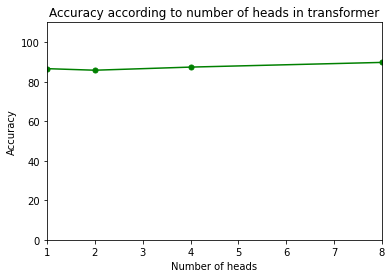

In [66]:
fig = plt.figure()

x = [1,2,4,8]

plt.plot(x, acc, 'g.-', markersize=10)

plt.xlabel('Number of heads')
plt.xlim([1,8])
plt.ylabel('Accuracy')
plt.ylim([0, 110])
plt.title('Accuracy according to number of heads in transformer')

plt.show()